In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from pathlib import Path
from dataclasses import dataclass

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

import chembl_webresource_client
from chembl_webresource_client.new_client import new_client

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statannot import add_stat_annotation

import scipy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
%load_ext autoreload
%autoreload 2

# Part 1
## Load data

In [4]:
@dataclass
class DbQuery:

    target: chembl_webresource_client.query_set.QuerySet = new_client.target
    target_query = target.search('coronavirus')
    targets = pd.DataFrame.from_dict(target_query)
    selected_target: str = targets.target_chembl_id[0]

In [6]:
@dataclass
class Coronavirus:

    target_name: str = DbQuery.targets.target_chembl_id[6]
    activity = new_client.activity
    activity = activity.filter(target_chembl_id=target_name).filter(standard_type="IC50")
    activity = pd.DataFrame.from_dict(activity)
    activity = activity[activity.standard_value.notna()]


## Preprocess data

In [7]:
conditions = [
    (Coronavirus.activity.standard_value.astype(float) >= 10_000),
    (Coronavirus.activity.standard_value.astype(float) <= 1000),
    ]

choices = ["inactive", "active"]
Coronavirus.activity["bioactivity_class"] = np.select(condlist=conditions, choicelist=choices, default="intermediate")

In [8]:
Coronavirus.preprocessed_data = pd.DataFrame()
names = ["molecule_chembl_id", "canonical_smiles", "bioactivity_class", "standard_value"]
for name in names:
    Coronavirus.preprocessed_data[name] = Coronavirus.activity[name]

# Coronavirus.activity.to_pickle("data/bioactivity_raw_data.pickle")
# Coronavirus.preprocessed_data.to_pickle("data/bioactivity_raw_data.pickle")

## Lipinsky descriptors

### References
* [Paper DOI](https://www.nature.com/articles/s41597-019-0151-1)
* [Source code](https://codeocean.com/explore/a3083b61-7861-4351-a71f-7a90c323add2?query=tag%3Adata-curation&page=1&filter=all)
### Notes
* Log(P) – solubility or water portion

In [9]:
def descript_data(canonical_smiles: pd.Series | list) -> pd.DataFrame:
    mol_data: pd.DataFrame = pd.DataFrame(
            columns=["molecular_weight", "water_portion_LogP", "numHDonors", "numHAcceptors"]
            )

    mol_data_list: list = [Chem.MolFromSmiles(elem) for elem in canonical_smiles]

    mol_data[mol_data.columns[0]] = [Descriptors.MolWt(mol) for mol in mol_data_list]
    mol_data[mol_data.columns[1]] = [Descriptors.MolLogP(mol) for mol in mol_data_list]
    mol_data[mol_data.columns[2]] = [Lipinski.NumHDonors(mol) for mol in mol_data_list]
    mol_data[mol_data.columns[3]] = [Lipinski.NumHAcceptors(mol) for mol in mol_data_list]

    return mol_data

In [10]:
mol_data = descript_data(canonical_smiles=Coronavirus.preprocessed_data.canonical_smiles)
mol_data = mol_data.astype(
        {
            'numHAcceptors'   : np.int8, 'numHDonors': np.int8,
            'molecular_weight': np.float16, 'water_portion_LogP': np.float16
            }
        )
# mol_data.to_pickle("data/Lipinsky_descriptor_data.pickle")

## Convert IC50 to plIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50)

In [12]:
@dataclass
class Data:
    raw = pd.read_pickle('data/bioactivity_raw_data.pickle')
    preprocessed = pd.read_pickle('data/bioactivity_preprocessed_data.pickle')
    mol_data = pd.read_pickle('data/Lipinsky_descriptor_data.pickle')

    data = pd.concat([preprocessed, mol_data], axis=1)
    data = data.drop_duplicates()
    data = data.astype(
            {
                'standard_value'   : np.float64,
                'bioactivity_class': str,
                'canonical_smiles' : str
                }
            )
    data = data.rename(columns={'standard_value': 'IC50'})
    data.IC50 = data.IC50.mask(data.IC50 >= 10 ** 9, 10 ** 9)
    data['pIC50'] = -np.log10(data.IC50 * 10 ** -9)

#Data.data.to_pickle("data/processed_data.pickle")

# Part 2

In [13]:
cond = Data.data.bioactivity_class != 'intermediate'
df = Data.data[cond]

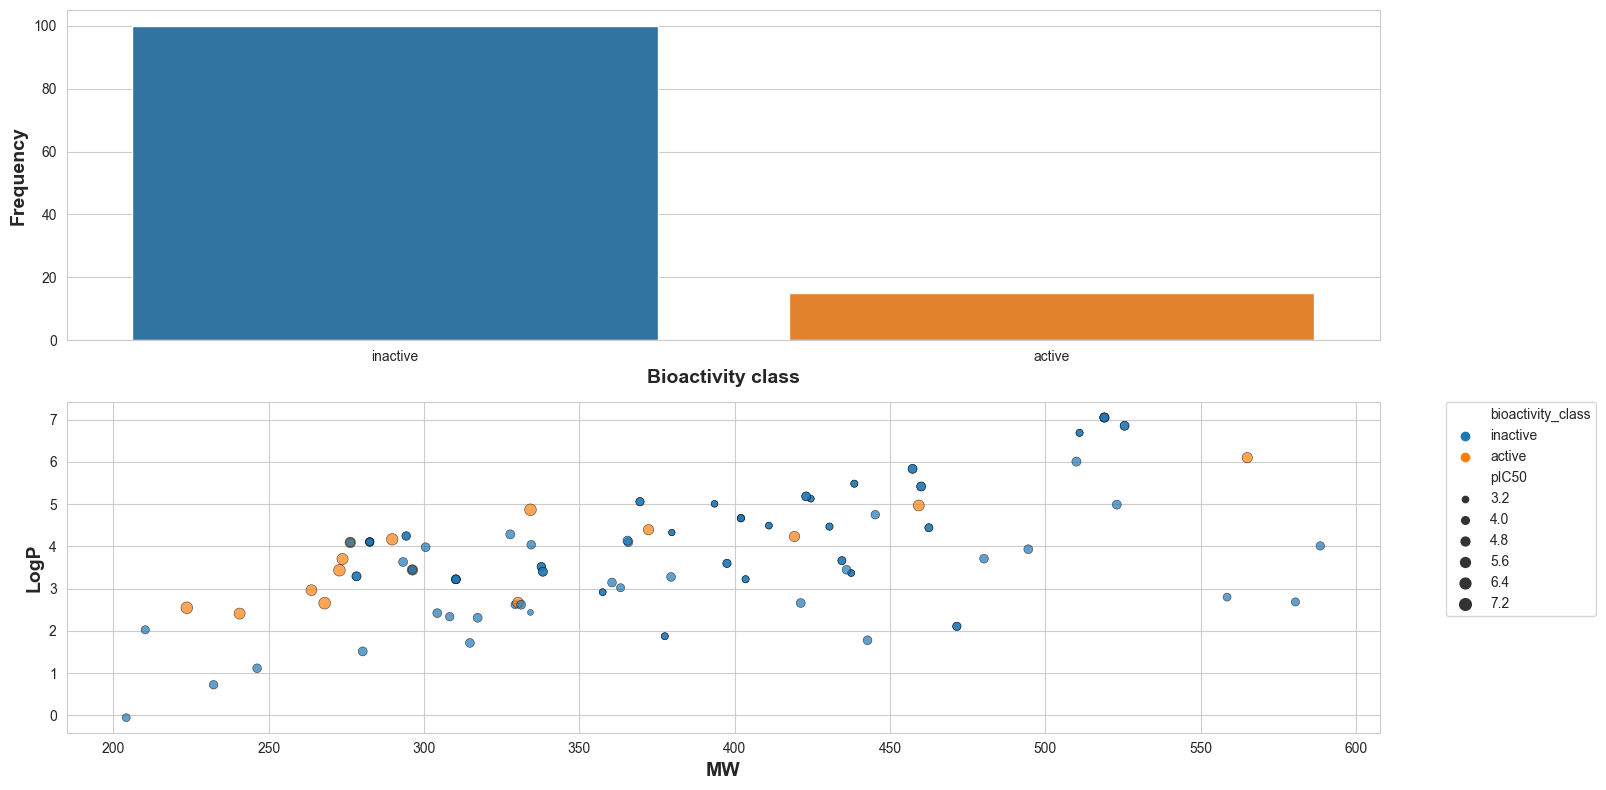

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(14, 8))

sns.countplot(x='bioactivity_class', data=df, ax=axs[0])
axs[0].set_xlabel('Bioactivity class', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Frequency', fontsize=14, fontweight='bold')

sns.scatterplot(
        x='molecular_weight', y='water_portion_LogP', data=df, ax=axs[1], hue='bioactivity_class', edgecolor='black',
        alpha=0.7, size='pIC50'
        )
axs[1].set_xlabel('MW', fontsize=14, fontweight='bold')
axs[1].set_ylabel('LogP', fontsize=14, fontweight='bold')

fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## Box plots

In [15]:
def mann_whitneyu_test(name: str, data: pd.DataFrame = df):
    g_1 = getattr(data, name)[df.bioactivity_class == 'active']
    g_2 = getattr(data, name)[df.bioactivity_class == 'inactive']
    stat, p_val = scipy.stats.mannwhitneyu(g_1, g_2)
    alpha = 0.5
    interpretation = 'same' if p_val > alpha else 'different'

    return stat, p_val, alpha, interpretation

In [16]:
names = ['pIC50', 'molecular_weight', 'water_portion_LogP', 'numHDonors', 'numHAcceptors']
stats = pd.DataFrame(columns=names)
for name in names:
    stats[name] = mann_whitneyu_test(name=name)
stats = stats.T
stats.columns = ['stats', 'p_val', 'alpha', 'interpretation']

In [17]:
stats

,stats,p_val,alpha,interpretation
pIC50,1500.0,0.0,0.5,different
molecular_weight,401.0,0.003797,0.5,different
water_portion_LogP,694.5,0.647804,0.5,same
numHDonors,297.5,0.000072,0.5,different
numHAcceptors,413.0,0.004651,0.5,different


inactive v.s. active: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.800e-10 U_stat=0.000e+00
inactive v.s. active: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.797e-03 U_stat=1.099e+03
inactive v.s. active: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.478e-01 U_stat=8.055e+02
inactive v.s. active: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.172e-05 U_stat=1.202e+03
inactive v.s. active: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.651e-03 U_stat=1.087e+03


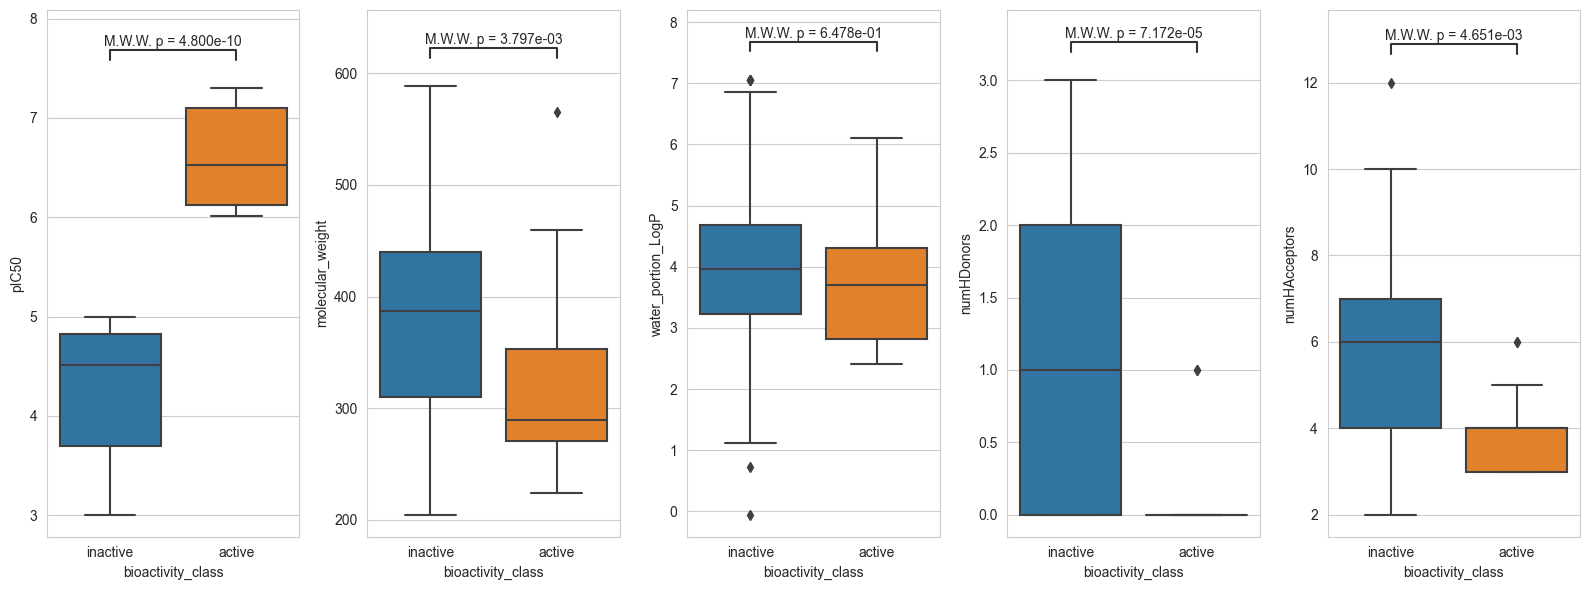

In [18]:
fig, axs = plt.subplots(ncols=5, figsize=(16, 6))
for index, name in enumerate(names):
    sns.boxplot(x='bioactivity_class', y=name, data=df, ax=axs[index])
    add_stat_annotation(
            ax=axs[index], data=df, x='bioactivity_class', y=name,
            box_pairs=[('inactive', 'active')],
            test='Mann-Whitney', text_format='full', loc='inside',
            verbose=5
            )
plt.tight_layout()

# Part 3

In [19]:
df = pd.read_pickle('data/processed_data.pickle')
# next file would be processed by JAVA descriptor
# df[['canonical_smiles', 'molecule_chembl_id']].to_csv('molecule.smi')

## Java script
Use it with file contained "canonical_smiles" and "molecule_chembl_id". The data stores in the molecule.smi file

In [20]:
descriptor_output = pd.read_csv('data/descriptor_output.csv')
df_x = descriptor_output.drop('Name', axis=1)
df_y = pd.read_pickle('data/processed_data.pickle')['pIC50']
df = pd.concat([df_x, df_y], axis=1)
df = df.dropna()
# df.to_pickle('data/coronavirus_bioactivity_data_3class_pIC50_pubchem_fp.pickle')

# Part 4 Model creation

In [21]:
X: pd.DataFrame = pd.read_pickle('data/coronavirus_bioactivity_data_3class_pIC50_pubchem_fp.pickle').drop(
    'pIC50', axis=1
    )
Y: pd.DataFrame = pd.read_pickle('data/coronavirus_bioactivity_data_3class_pIC50_pubchem_fp.pickle')['pIC50']

In [22]:
from sklearn.feature_selection import VarianceThreshold

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = selection.fit_transform(X)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3)

In [24]:
np.random.seed(1000)
model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)
r2 = model.score(x_test, y_test)

In [25]:
y_pred = model.predict(x_test)

<Axes: xlabel='pIC50'>

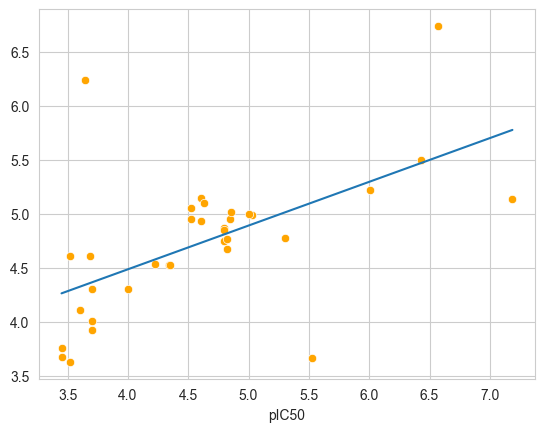

In [26]:
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
sns.scatterplot(x=y_test, y=y_pred, color='orange')
sns.lineplot(x=y_test, y=p(y_test))

# ML

In [28]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [46]:
(x_train.shape,x_test.shape,
 y_train.shape, y_test.shape)

((78, 197), (34, 197), (78,), (34,))

In [51]:
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
train, test = clf.fit(x_train, x_test, y_train, y_test)

100%|██████████| 42/42 [00:14<00:00,  2.94it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 159
[LightGBM] [Info] Start training from score 4.741610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [54]:
test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,63153603640420986503209036886578436547543340604...,-3138542726372436495132772422229831197098165464...,16278870011795575499860406504295435584157297573...,0.23
LinearRegression,12162334652463455404032.00,-60443117666788073013248.00,225909066654.65,0.27
TransformedTargetRegressor,12162334652463455404032.00,-60443117666788073013248.00,225909066654.65,0.18
KernelRidge,6.21,-24.89,4.68,0.19
GaussianProcessRegressor,3.91,-13.47,3.50,0.27
MLPRegressor,1.31,-0.53,1.14,0.34
OrthogonalMatchingPursuit,1.30,-0.47,1.11,0.01
LinearSVR,1.27,-0.32,1.06,0.04
HuberRegressor,1.27,-0.32,1.06,0.02


## Data visualisation

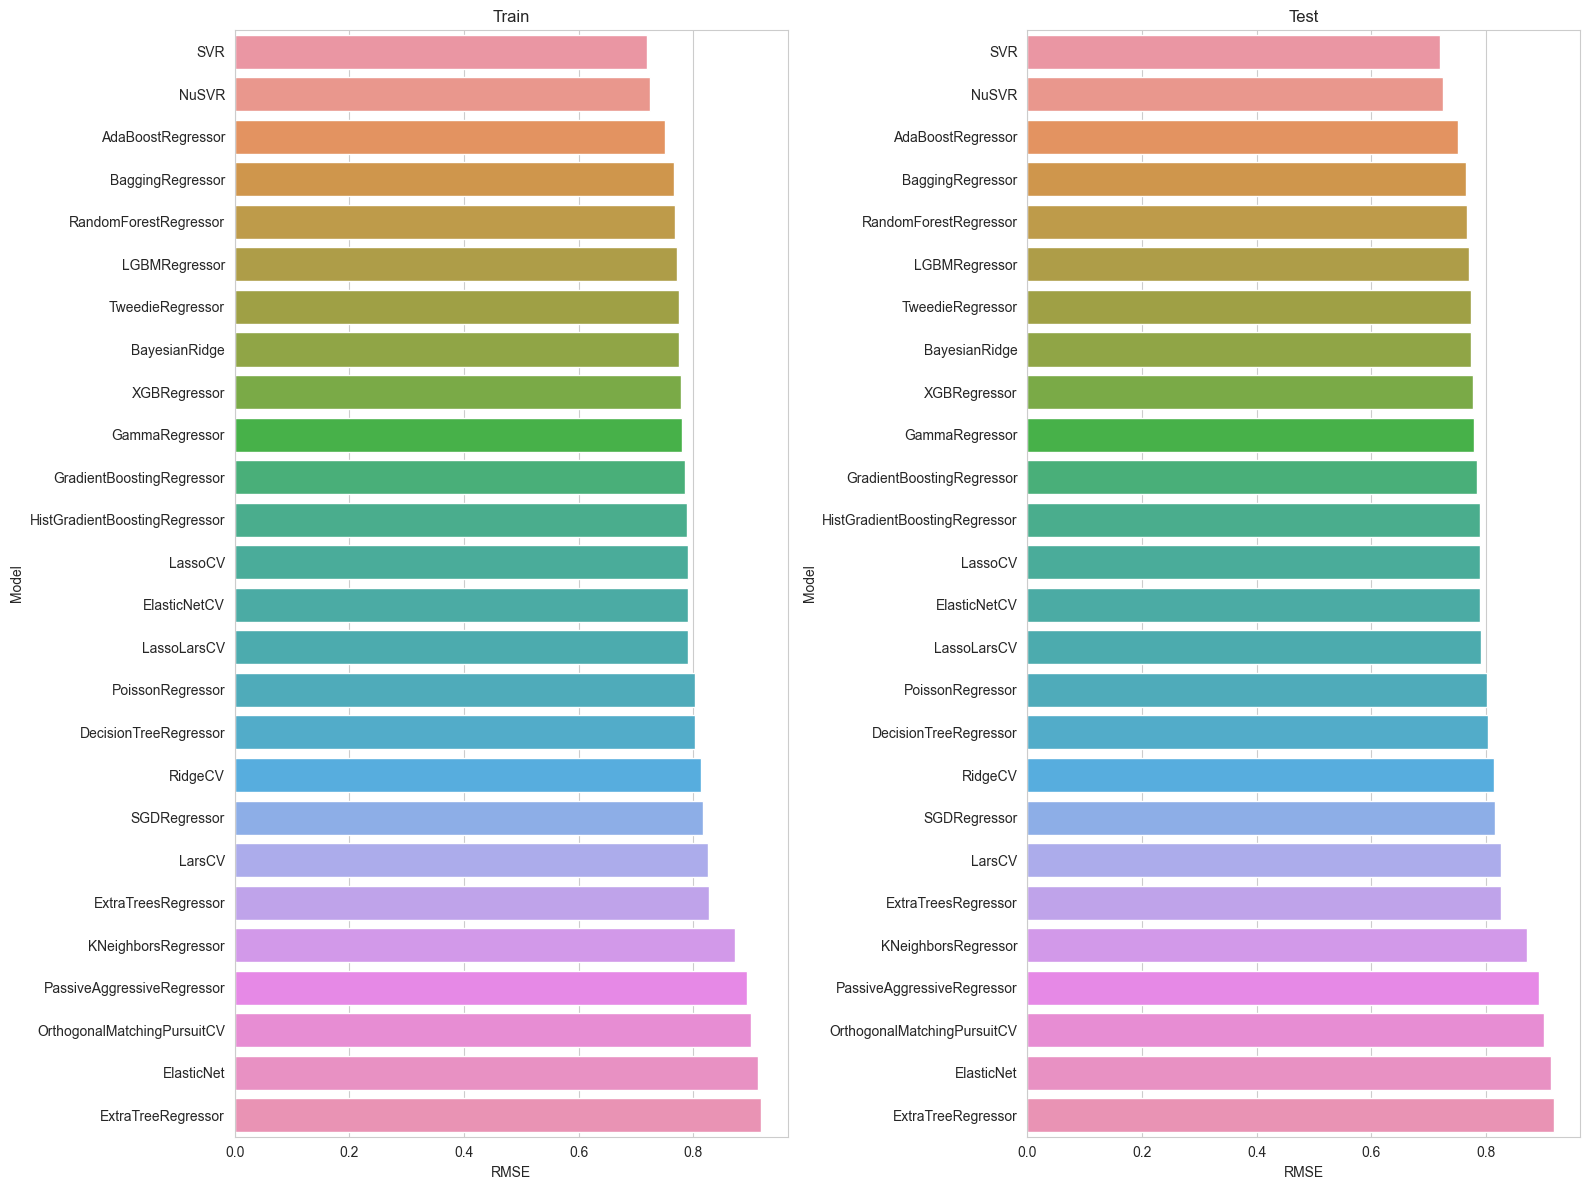

In [53]:
figure, axs = plt.subplots(figsize=(16, 12), ncols=2)

y_data_train = train[train['R-Squared'] > 0].sort_values('R-Squared', ascending=False).index
fig_data_train = train[train['R-Squared'] > 0].sort_values('R-Squared', ascending=False)

y_data_test = test[train['R-Squared'] > 0].sort_values('R-Squared', ascending=False).index
fig_data_test = test[train['R-Squared'] > 0].sort_values('R-Squared', ascending=False)

sns.barplot(y=y_data_train, x='RMSE', data=fig_data_train, ax=axs[0]).set(title='Train')
sns.barplot(y=y_data_test, x='RMSE', data=fig_data_test, ax=axs[1]).set(title='Test')

plt.tight_layout()
plt.show()

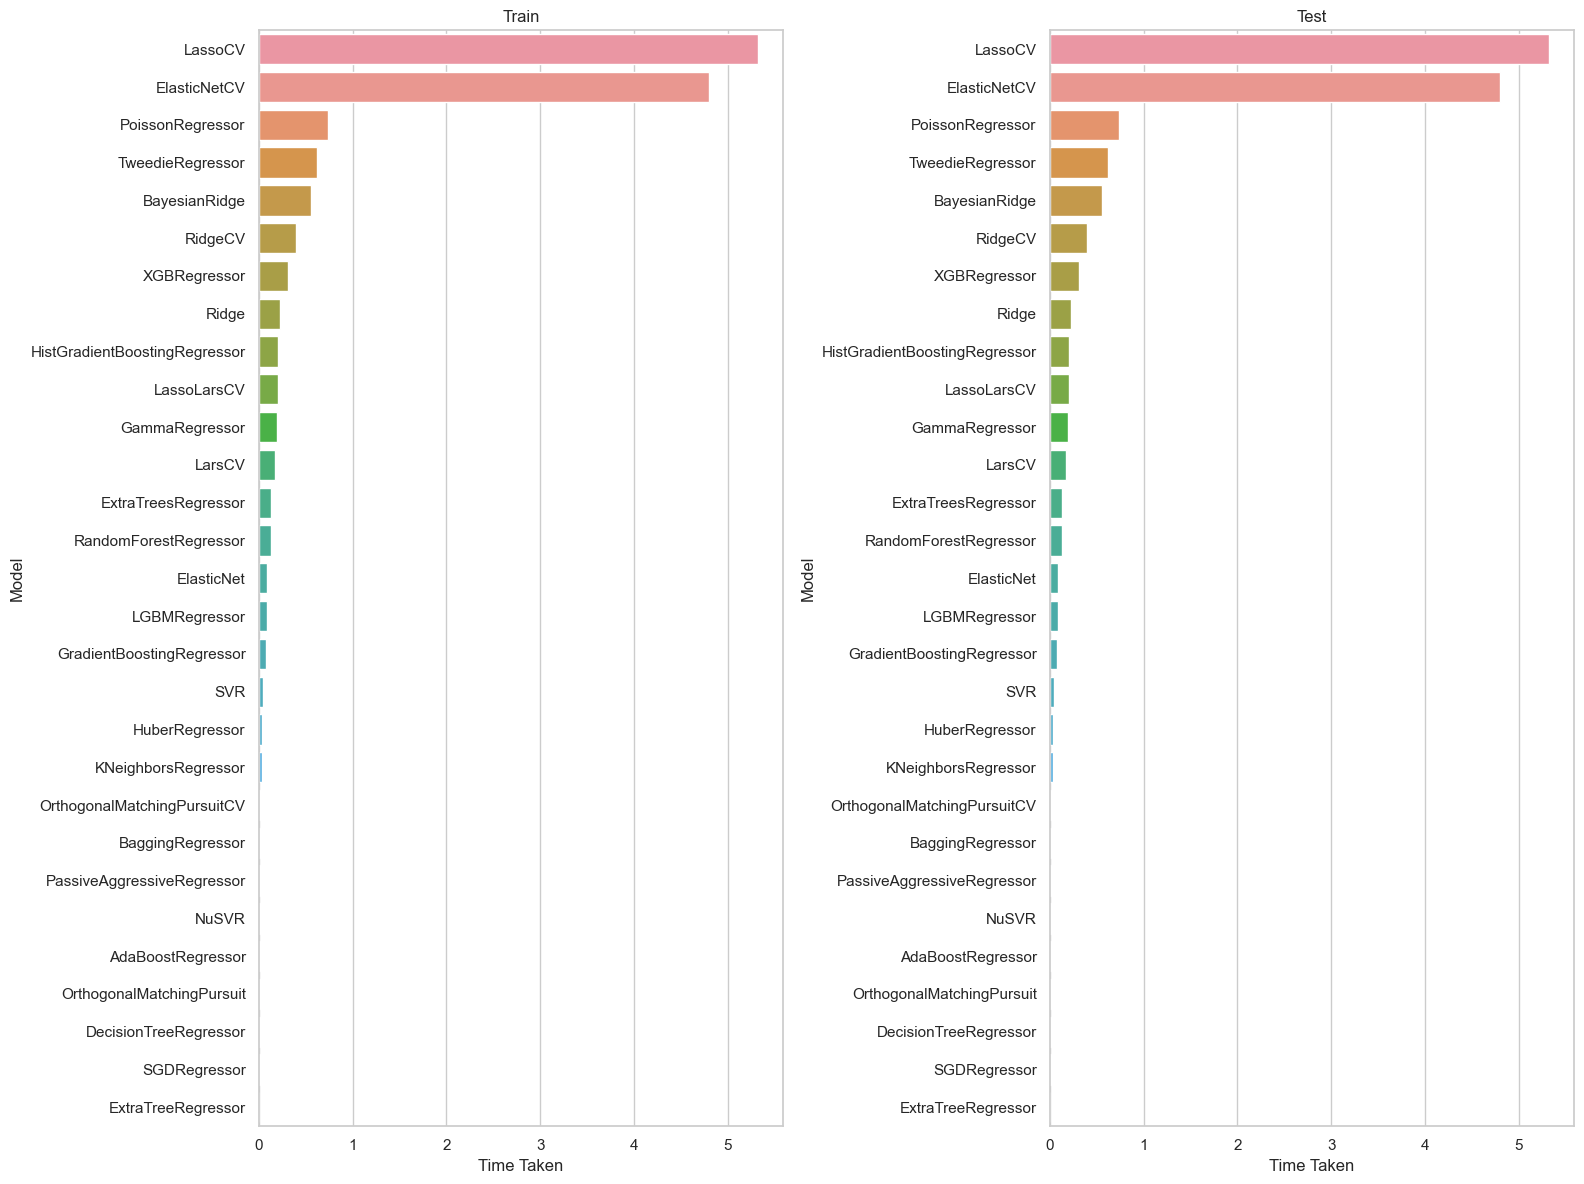

In [202]:
figure, axs = plt.subplots(figsize=(16, 12), ncols=2)

y_data_train = train[train['R-Squared'] > 0].sort_values('Time Taken', ascending=False).index
fig_data_train = train[train['R-Squared'] > 0].sort_values('Time Taken', ascending=False)

y_data_test = test[test['R-Squared'] > 0].sort_values('Time Taken', ascending=False).index
fig_data_test = test[test['R-Squared'] > 0].sort_values('Time Taken', ascending=False)

sns.barplot(y=y_data_train, x='Time Taken', data=fig_data_train, ax=axs[0]).set(title='Train')
sns.barplot(y=y_data_test, x='Time Taken', data=fig_data_test, ax=axs[1]).set(title='Test')

plt.tight_layout()
plt.show()